In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import umap
import nltk
import spacy
import string
import hdbscan

import preprocessor as p

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

nlp = spacy.load("en_core_web_sm")

In [2]:
df = pd.read_csv('mindvalley_fb_comments.csv')
df.rename(columns={"comment":"comments"},inplace=True)
df.head()

,Unnamed: 0,comments
0,0,After this class you'll see why Silicon Valley...
1,1,The shirt is almost identical to my moms fancy...
2,2,"When you buy a program, can you stop, backup,..."
3,3,Exactly what is lucid dreaming? Thank you for ...
4,4,"I have lucid dreams all the time, also have ov..."


In [3]:
df.comments.replace("\n" , " ", regex=True, inplace = True)
df.comments=df.comments.apply(lambda x:p.clean(str(x)))

In [4]:
df.replace('nan', np.nan, inplace = True)
df.replace('', np.nan, inplace = True)
df.replace('do', np.nan, inplace = True)
df = df.dropna()

In [5]:
list_data = df.comments.unique().tolist()

In [6]:
len(list_data)

1053

In [7]:
from sentence_transformers import SentenceTransformer

In [8]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1
# roberta-large-nli-stsb-mean-tokens
#allenai-specter


In [9]:
model=SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
embeddings = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

In [10]:
best_model = umap.UMAP(n_components=5).fit_transform(embeddings)

#n_neighbors=10, min_dist=0.0, 

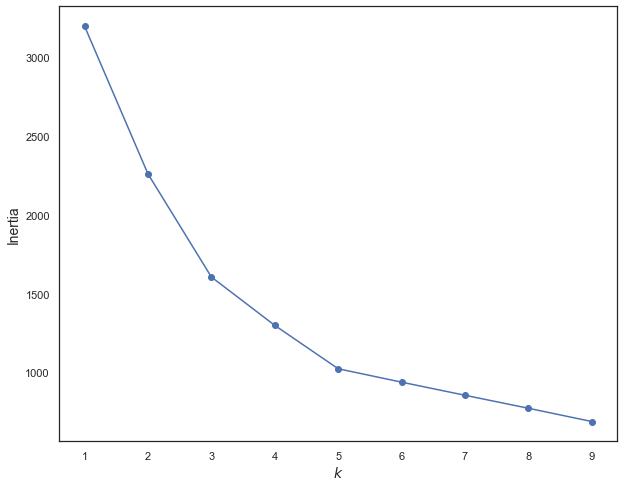

In [11]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(best_model)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [12]:
# from nltk.cluster import KMeansClusterer,euclidean_distance
# clusterer =KMeansClusterer(6,euclidean_distance)
# cluster=np.array(clusterer.cluster(best_model,True))

In [13]:
# cluster = KMeans(n_clusters=1, init="k-means++").fit_predict(best_model)

In [14]:
cluster = hdbscan.HDBSCAN().fit_predict(best_model)

In [15]:
def plot(cluster = cluster):    

    clustered = (cluster >= 0)
    reduced_dim = umap.UMAP(n_components=2).fit_transform(embeddings)



    unique, counts = np.unique(cluster, return_counts=True)
    print(dict(zip(unique, counts)))

    plt.scatter(reduced_dim[~clustered, 0],
                reduced_dim[~clustered, 1],
                c=(0.5,0.5,0.5),
                # s=1,
                alpha=0.5
                )
    plt.scatter(reduced_dim[clustered, 0],
                reduced_dim[clustered, 1],
                c=cluster[clustered],
                # s=1,
                cmap='Accent')
    plt.show()

{-1: 510, 0: 6, 1: 13, 2: 20, 3: 6, 4: 7, 5: 22, 6: 6, 7: 23, 8: 22, 9: 11, 10: 6, 11: 48, 12: 8, 13: 6, 14: 27, 15: 24, 16: 7, 17: 15, 18: 5, 19: 8, 20: 6, 21: 8, 22: 10, 23: 6, 24: 8, 25: 14, 26: 10, 27: 35, 28: 5, 29: 5, 30: 22, 31: 7, 32: 12, 33: 21, 34: 27, 35: 9, 36: 22, 37: 7, 38: 19}


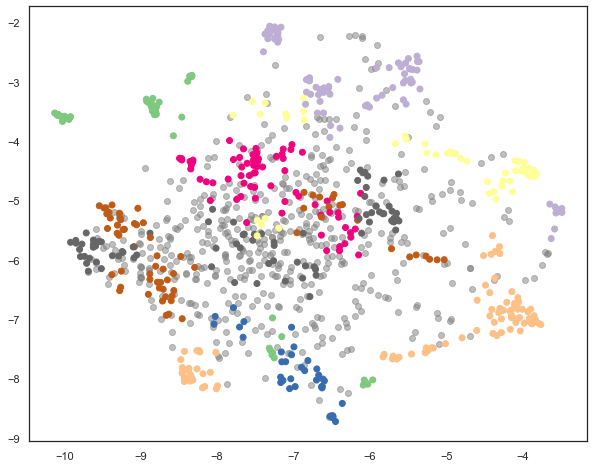

In [16]:
plot()

In [17]:
len(cluster)

1053

In [18]:
def word_root(text):
    list_data3=[]
    doc = nlp(text)
    for token in doc:
        if token.text.isalpha() and len(token.text)>2:
            lemma = token.lemma_
            list_data3.append(lemma)
        else:pass
    return " ".join(list_data3)

In [19]:
word_root("urgent urgently urgents urgented urge urgentment")

'urgent urgently urgent urgented urge urgentment'

In [20]:
docs = pd.DataFrame(list_data,columns=["comments"])
docs["cluster"] = cluster
labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"comments": " ".join})
labeled_docs.comments = labeled_docs.comments.apply(lambda x: word_root(str(x).lower()))  
labeled_docs

,cluster,comments
0,-1,after this class you see why silicon valley co...
1,0,sorry for post message here really need your h...
2,1,genuine faithful love loving care encourage gr...
3,2,its opportunity learn and grow and understand ...
4,3,what beautiful woman such beautiful woman and ...
5,4,totally sign people welcome happy morning hell...
6,5,prayer protect you and cure our lord have wron...
7,6,every time exercise learn how you can get fitt...
8,7,join charlie and vishen lakhiani brand new mas...
9,8,exactly what lucid dreaming thank you for your...


In [21]:
from keybert import KeyBERT
array_text = labeled_docs.comments.tolist()
kw_extractor = KeyBERT(model=model)
bigram=[]
for j in range(len(array_text)-1):
    keywords = kw_extractor.extract_keywords(array_text[j+1],top_n=10,keyphrase_ngram_range=(2, 2))
    print(f'\033[1m   Bigram Cluster {j+1}: \033[0m' )
    print([word for word in keywords])
    bigram.append([word[0] for word in keywords])

   Bigram Cluster 1: 
[('militer mohon', 0.5886), ('military want', 0.5092), ('stop military', 0.4459), ('military kindly', 0.4426), ('urge urgent', 0.4245), ('perhatian mendesak', 0.424), ('need urgent', 0.4211), ('mohon bantu', 0.4156), ('detain military', 0.4139), ('military try', 0.4135)]
   Bigram Cluster 2: 
[('generous love', 0.605), ('kind love', 0.6018), ('faithful love', 0.6015), ('loving care', 0.5849), ('loving kind', 0.579), ('passionate kind', 0.5511), ('love loving', 0.549), ('loyal loving', 0.5471), ('love love', 0.5412), ('passionate loyal', 0.5374)]
   Bigram Cluster 3: 
[('learn history', 0.542), ('american history', 0.5032), ('teach history', 0.5004), ('educate black', 0.4963), ('history american', 0.4822), ('america history', 0.4773), ('black history', 0.4698), ('history teach', 0.4609), ('time learn', 0.4492), ('opportunity learn', 0.4467)]
   Bigram Cluster 4: 
[('woman beautiful', 0.6349), ('beautiful woman', 0.6339), ('woman beauty', 0.5806), ('humble woman', 0

In [22]:
unigram=[]
for j in range(len(array_text)-1):
    keywords = kw_extractor.extract_keywords(array_text[j+1],top_n=10,keyphrase_ngram_range=(1, 1))
    print(f'\033[1m   Unigram Cluster {j+1}: \033[0m' )
    print([word for word in keywords])
    unigram.append([word[0] for word in keywords])

   Unigram Cluster 1: 
[('mohon', 0.3645), ('bantu', 0.3622), ('military', 0.3551), ('militer', 0.3522), ('urgent', 0.35), ('membutuhkan', 0.3475), ('militar', 0.3202), ('mendesak', 0.315), ('menghentikan', 0.3133), ('want', 0.3117)]
   Unigram Cluster 2: 
[('compassion', 0.4741), ('loving', 0.445), ('love', 0.4364), ('passionate', 0.4203), ('respect', 0.4037), ('loyal', 0.3918), ('kind', 0.3448), ('faithful', 0.3431), ('supportive', 0.3324), ('generous', 0.3221)]
   Unigram Cluster 3: 
[('learn', 0.3224), ('commemorate', 0.3189), ('history', 0.2878), ('racism', 0.2807), ('america', 0.2689), ('american', 0.2682), ('african', 0.2597), ('educate', 0.2454), ('culture', 0.2422), ('explore', 0.241)]
   Unigram Cluster 4: 
[('beautiful', 0.4512), ('beauty', 0.4457), ('lovely', 0.3753), ('woman', 0.3197), ('beaitiful', 0.3192), ('speech', 0.2749), ('brave', 0.2689), ('humble', 0.2674), ('powerful', 0.2407), ('mama', 0.2346)]
   Unigram Cluster 5: 
[('welcome', 0.3999), ('hello', 0.3987), ('me

In [23]:
for i in range(len(array_text)-1):
    clusterer=[]
    bigramer=[]
    print(f'\033[1m   Cluster {i+1}: \033[0m')
    [clusterer.append(j) for j in unigram[i]]
    clusterer.append(bigram[i][0])
    
    for word in bigram[i][0].split(" "):
        if word not in bigramer:
            bigramer.append(word)
    
    for each in bigram[i]:
        first,second=each.split(" ")
        if first != second and not(first in bigramer and second in bigramer):
            clusterer.append(each)
            if bigramer.append(first): first not in bigramer
            if bigramer.append(second): second not in bigramer
    print(clusterer)

   Cluster 1: 
['mohon', 'bantu', 'military', 'militer', 'urgent', 'membutuhkan', 'militar', 'mendesak', 'menghentikan', 'want', 'militer mohon', 'military want', 'stop military', 'military kindly', 'urge urgent', 'perhatian mendesak', 'need urgent', 'mohon bantu', 'detain military', 'military try']
   Cluster 2: 
['compassion', 'loving', 'love', 'passionate', 'respect', 'loyal', 'kind', 'faithful', 'supportive', 'generous', 'generous love', 'kind love', 'faithful love', 'loving care', 'passionate kind', 'loyal loving']
   Cluster 3: 
['learn', 'commemorate', 'history', 'racism', 'america', 'american', 'african', 'educate', 'culture', 'explore', 'learn history', 'american history', 'teach history', 'educate black', 'america history', 'time learn', 'opportunity learn']
   Cluster 4: 
['beautiful', 'beauty', 'lovely', 'woman', 'beaitiful', 'speech', 'brave', 'humble', 'powerful', 'mama', 'woman beautiful', 'woman beauty', 'humble woman', 'lovely speech', 'beautiful mama', 'woman brave', 

In [24]:
len(sentences)

NameError: name 'sentences' is not defined

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')

sentences = array_text[1:]

#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.pytorch_cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

print("Top similar pairs:")
for score, i, j in all_sentence_combinations:
    print("cluster {} \t cluster {} \t similarity: {:.4f}".format(i+1, j+1, cos_sim[i][j]))